<a href="https://colab.research.google.com/github/alexfc14/Purchase-Optimization/blob/main/Simulaci%C3%B3n_y_Optimizaci%C3%B3n_de_Compras_(Colab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
# ----------------------------------------------------------------------------------
# Script de optimización de compras usando POO y pruebas unitarias.
#
# La clase Solution ha sido mejorada para mostrar todos los datos de un
# periodo en una sola tabla, facilitando el análisis.
# ----------------------------------------------------------------------------------

# 1. Instalación de librerías y solver GLPK (autónomo para Google Colab)
try:
    import pulp
except ImportError:
    !sudo apt-get install -y glpk-utils
    !pip install pulp pandas
    import pulp
    print("Librerías y solver instalados: PuLP, pandas y GLPK.")

import numpy as np
import pandas as pd
import pulp

# ----------------------------------------------------------------------------------
# 2. Clases del Modelo de Optimización
# ----------------------------------------------------------------------------------

class ProblemParameters:
    """
    Clase para almacenar todos los datos y parámetros del problema de optimización.
    """
    def __init__(self, K: int, M: int, T: int):
        self.K = K  # Número de productos
        self.M = M  # Número de proveedores
        self.T = T  # Número de períodos de tiempo
        # Inicializar todos los atributos de datos a None
        self.D = None                     # Matriz de demanda D[i][t]
        self.S_0 = None                   # Vector de stock inicial S_0[i]
        self.costo_compra = None          # Tensor de costo de compra C[i][j][t]
        self.costo_almacenamiento = None  # Vector de costo de almacenamiento H[i]
        self.S_capacidad = None           # Tensor de capacidad de suministro del proveedor S_cap[i][j][t]
        self.minimo_pedido = None         # Tensor de cantidad mínima de pedido min_p[i][j][t]
        self.costo_fijo_pedido = None     # Tensor de costo fijo de pedido F[i][j][t]
        self.volumen_unitario = None      # Vector de volumen por unidad V[i]
        self.C_cap = None                 # Capacidad total del almacén C_cap

    def simulate_data(self, seed: int = 42):
        """Genera datos aleatorios para el problema."""
        np.random.seed(seed)
        self.D = np.random.randint(50, 200, size=(self.K, self.T))
        self.S_0 = np.random.randint(10, 50, size=self.K)
        self.costo_compra = np.random.uniform(5, 20, size=(self.K, self.M, self.T))
        self.costo_almacenamiento = np.random.uniform(0.5, 2, size=self.K)
        self.S_capacidad = np.random.randint(100, 500, size=(self.K, self.M, self.T))
        self.minimo_pedido = np.random.randint(20, 50, size=(self.K, self.M, self.T))
        self.costo_fijo_pedido = np.random.uniform(5, 25, size=(self.K, self.M, self.T))
        self.volumen_unitario = np.random.uniform(0.1, 0.5, size=self.K)
        self.C_cap = 1500

class PurchaseModel:
    """
    Clase para formular y resolver el modelo de optimización.
    """
    def __init__(self, params: ProblemParameters):
        self.params = params
        self.model = pulp.LpProblem("Plan_de_Compras_Optimo", pulp.LpMinimize)
        self.p = None
        self.s = None
        self.y = None
        self._formulate()

    def _formulate(self):
        """Formula el modelo con la función objetivo y las restricciones."""
        # Variables de decisión
        # p[i][j][t]: Cantidad de producto 'i' a comprar al proveedor 'j' en el período 't'.
        p = pulp.LpVariable.dicts("p", (range(self.params.K), range(self.params.M), range(self.params.T)), lowBound=0, cat='Continuous')
        # s[i][t]: Cantidad de stock del producto 'i' al final del período 't'.
        s = pulp.LpVariable.dicts("s", (range(self.params.K), range(self.params.T)), lowBound=0, cat='Continuous')
        # y[i][j][t]: Variable binaria, 1 si se realiza un pedido del producto 'i' al proveedor 'j' en el período 't', 0 en caso contrario.
        y = pulp.LpVariable.dicts("y", (range(self.params.K), range(self.params.M), range(self.params.T)), cat='Binary')
        self.p, self.s, self.y = p, s, y

        # Función objetivo: Minimizar el costo total
        # Costo de compra: Suma del costo de compra por unidad por la cantidad comprada.
        coste_total_compra = pulp.lpSum(self.params.costo_compra[i, j, t] * p[i][j][t] for i in range(self.params.K) for j in range(self.params.M) for t in range(self.params.T))
        # Costo de almacenamiento: Suma del costo de almacenamiento por unidad por el stock al final de cada período.
        coste_total_almacenamiento = pulp.lpSum(self.params.costo_almacenamiento[i] * s[i][t] for i in range(self.params.K) for t in range(self.params.T))
        # Costo fijo de pedido: Suma del costo fijo por cada pedido realizado.
        coste_fijo_total = pulp.lpSum(self.params.costo_fijo_pedido[i, j, t] * y[i][j][t] for i in range(self.params.K) for j in range(self.params.M) for t in range(self.params.T))
        self.model += coste_total_compra + coste_total_almacenamiento + coste_fijo_total, "Costo Total"

        # Restricciones
        for i in range(self.params.K):
            for t in range(self.params.T):
                # Restricción de balance de inventario:
                # Stock_final = Stock_inicial + Compras - Demanda
                balance = self.params.S_0[i] if t == 0 else s[i][t-1]
                self.model += balance + pulp.lpSum(p[i][j][t] for j in range(self.params.M)) - self.params.D[i, t] == s[i][t], f"Balance_Inv_{i}_{t}"

        for i in range(self.params.K):
            for j in range(self.params.M):
                for t in range(self.params.T):
                    # Restricción de capacidad de proveedor
                    self.model += p[i][j][t] <= self.params.S_capacidad[i, j, t]
                    # Restricción de pedido mínimo:
                    # Si se realiza un pedido (y[i][j][t] es 1), la cantidad comprada debe ser al menos el mínimo de pedido.
                    self.model += p[i][j][t] >= self.params.minimo_pedido[i, j, t] * self.y[i][j][t]
                    # Restricción que asegura que si no se hace un pedido (y=0), la cantidad comprada p[i][j][t] debe ser 0.
                    self.model += p[i][j][t] <= self.params.S_capacidad[i, j, t] * self.y[i][j][t]

        for t in range(self.params.T):
            # Restricción de capacidad de almacén:
            # El volumen total del stock al final de cada período no debe exceder la capacidad del almacén.
            self.model += pulp.lpSum(s[i][t] * self.params.volumen_unitario[i] for i in range(self.params.K)) <= self.params.C_cap

    def solve(self):
        """Resuelve el modelo y devuelve un objeto Solution si es óptimo."""
        self.model.solve(pulp.GLPK(msg=0))
        if self.model.status == pulp.LpStatusOptimal:
            return Solution(self.model, self.p, self.s, self.params)
        return None

class Solution:
    """
    Clase para almacenar y presentar los resultados de una solución óptima.
    """
    def __init__(self, model, p, s, params):
        self.model = model
        self.p = p
        self.s = s
        self.params = params
        self.objective_value = pulp.value(model.objective)
        self.status = pulp.LpStatus[model.status]

    def display(self, message: str = ""):
        """Imprime los resultados en un formato legible y unificado, ordenado por tiempo."""
        print(f"\n--- {message} ---")
        if self.model.status == pulp.LpStatusOptimal:
            print(f"Estado de la solución: {self.status}")
            print(f"Costo total mínimo: ${self.objective_value:,.2f}")

            resultados_unificados = []
            # Iterar por período primero, para ordenar la visualización por tiempo
            for t in range(self.params.T):
                for i in range(self.params.K):
                    compras_detalle = []
                    costos_detalle = []

                    for j in range(self.params.M):
                        cantidad = pulp.value(self.p[i][j][t])
                        if cantidad is not None and cantidad > 1e-6:
                            compras_detalle.append(f"Pr{j+1}: {cantidad:.2f} unid.")
                            costos_detalle.append(f"Pr{j+1}: ${self.params.costo_compra[i, j, t]:.2f}")

                    if not compras_detalle:
                        compras_detalle.append("Ninguna")
                        costos_detalle.append("N/A")

                    resultados_unificados.append({
                        'Periodo': f'T{t+1}',
                        'Producto': f'P{i+1}',
                        'Demanda': self.params.D[i, t],
                        'Compras': "\n".join(compras_detalle),
                        'Stock Final': pulp.value(self.s[i][t]),
                        'Costo Unitario': "\n".join(costos_detalle)
                    })

            df_resultados = pd.DataFrame(resultados_unificados)
            print("\nResumen del Plan de Compras y Almacenamiento:")
            print(df_resultados.to_string(index=False))

        else:
            print(f"--- No se pudo encontrar una solución. Estado: {self.status} ---")

# ----------------------------------------------------------------------------------
# 3. Pruebas unitarias
# ----------------------------------------------------------------------------------

def test_variable_demand_and_price():
    """
    Prueba el escenario donde el modelo compra por adelantado en el periodo
    de bajo costo para satisfacer la demanda de alto costo.
    """
    print("\n--- TEST: Demanda y Precio Variables ---")
    params = ProblemParameters(K=1, M=1, T=2)
    params.D = np.array([[10, 100]])
    params.S_0 = np.array([0])
    params.costo_compra = np.array([[[10, 50]]])
    params.costo_almacenamiento = np.array([1])
    params.S_capacidad = np.array([[[500, 500]]])
    params.minimo_pedido = np.array([[[1, 1]]])
    params.costo_fijo_pedido = np.array([[[1, 1]]])
    params.volumen_unitario = np.array([1])
    params.C_cap = 500

    model = PurchaseModel(params)
    sol = model.solve()
    assert sol is not None, "La solución no debería ser nula"
    # Comportamiento esperado: se compra en T1 para cubrir la demanda de T1 y T2
    assert pulp.value(sol.p[0][0][0]) > 0, "No se realizó la compra en el primer período."
    assert pulp.value(sol.p[0][0][1]) < 1e-6, "Se realizó una compra en el segundo período, lo cual no es óptimo."
    print("✓ Test Demanda y Precio Variables: PASADO.")


def test_wholesale_vs_standard_supplier():
    """
    Prueba el escenario donde el modelo descarta un proveedor mayorista
    debido a un pedido mínimo demasiado grande.
    """
    print("\n--- TEST: Proveedor Mayorista ---")
    params = ProblemParameters(K=1, M=2, T=1)
    params.D = np.array([[100]])
    params.S_0 = np.array([0])
    params.costo_compra = np.array([[[2.0], [5.0]]])
    params.costo_almacenamiento = np.array([0])
    params.S_capacidad = np.array([[[1000], [100]]])
    params.minimo_pedido = np.array([[[1000], [10]]])
    params.costo_fijo_pedido = np.array([[[10], [10]]])
    params.volumen_unitario = np.array([1])
    params.C_cap = 500

    model = PurchaseModel(params)
    sol = model.solve()
    assert sol is not None, "La solución no debería ser nula"
    # Comportamiento esperado: se compra del proveedor 1, no del 0 (mayorista)
    assert pulp.value(sol.p[0][0][0]) < 1e-6, "Se compró del mayorista, lo cual no es óptimo."
    assert abs(pulp.value(sol.p[0][1][0]) - params.D[0,0]) < 1e-6, "No se compró la cantidad exacta del proveedor razonable."
    print("✓ Test Proveedor Mayorista: PASADO.")


def test_zero_storage_capacity():
    """
    Prueba el escenario donde la capacidad de almacenamiento es cero,
    forzando al modelo a comprar la cantidad justa para la demanda.
    """
    print("\n--- TEST: Capacidad de Almacenamiento Cero ---")
    params = ProblemParameters(K=1, M=1, T=2)
    params.D = np.array([[100, 150]])
    params.S_0 = np.array([0])
    params.costo_compra = np.array([[[10, 10]]])
    params.costo_almacenamiento = np.array([100])
    params.S_capacidad = np.array([[[500, 500]]])
    params.minimo_pedido = np.array([[[1, 1]]])
    params.costo_fijo_pedido = np.array([[[1, 1]]])
    params.volumen_unitario = np.array([1])
    params.C_cap = 0 # Capacidad de almacén cero

    model = PurchaseModel(params)
    sol = model.solve()
    assert sol is not None, "La solución no debería ser nula"
    # Comportamiento esperado: comprar solo la demanda de cada período y no almacenar nada.
    assert abs(pulp.value(sol.p[0][0][0]) - params.D[0, 0]) < 1e-6, "No se compró la cantidad exacta para la demanda del Periodo 1."
    assert abs(pulp.value(sol.p[0][0][1]) - params.D[0, 1]) < 1e-6, "No se compró la cantidad exacta para la demanda del Periodo 2."
    assert pulp.value(sol.s[0][0]) < 1e-6, "Se almacenó, lo cual no es óptimo con capacidad cero."
    print("✓ Test Capacidad de Almacenamiento Cero: PASADO.")


def test_liquidation_scenario():
    """
    Prueba el escenario de liquidación, donde el stock inicial es suficiente
    para cubrir toda la demanda, por lo que no se necesita comprar nada.
    """
    print("\n--- TEST: Escenario de Liquidación ---")
    params = ProblemParameters(K=1, M=1, T=1)
    params.D = np.array([[50]])
    params.S_0 = np.array([50])
    params.costo_compra = np.array([[[10]]])
    params.costo_almacenamiento = np.array([1])
    params.S_capacidad = np.array([[[500]]])
    params.minimo_pedido = np.array([[[1]]])
    params.costo_fijo_pedido = np.array([[[1]]])
    params.volumen_unitario = np.array([1])
    params.C_cap = 500

    model = PurchaseModel(params)
    sol = model.solve()
    assert sol is not None, "La solución no debería ser nula"
    # Comportamiento esperado: no comprar nada, el stock inicial es suficiente.
    assert pulp.value(sol.p[0][0][0]) < 1e-6, "Se realizó una compra a pesar de que el stock inicial es suficiente."
    assert pulp.value(sol.s[0][0]) < 1e-6, "No se consumió todo el stock."
    print("✓ Test Escenario de Liquidación: PASADO.")


def run_all_tests():
    """Ejecuta todas las funciones de prueba definidas."""
    print("\n==============================================")
    print("      Ejecutando Pruebas Unitarias del Modelo")
    print("==============================================")

    test_variable_demand_and_price()
    test_wholesale_vs_standard_supplier()
    test_zero_storage_capacity()
    test_liquidation_scenario()

    print("\n==============================================")
    print("  Todas las pruebas unitarias han pasado con éxito.")
    print("==============================================")


# ----------------------------------------------------------------------------------
# 4. Bloque de ejecución principal
# ----------------------------------------------------------------------------------
if __name__ == "__main__":
    # --- Simulación y resolución del caso general ---
    print("--- 1. Ejecutando el caso general (simulado) ---")
    # Definir las dimensiones del problema
    K_general, M_general, T_general = 5, 3, 4

    # Crear los objetos
    params_general = ProblemParameters(K_general, M_general, T_general)
    params_general.simulate_data()
    model_general = PurchaseModel(params_general)

    # Resolver y presentar los resultados
    solution_general = model_general.solve()
    if solution_general:
        solution_general.display(message="Solución del Caso General")

    # --- Ejecutar las pruebas unitarias ---
    run_all_tests()


--- 1. Ejecutando el caso general (simulado) ---

--- Solución del Caso General ---
Estado de la solución: Optimal
Costo total mínimo: $19,884.24

Resumen del Plan de Compras y Almacenamiento:
Periodo Producto  Demanda                              Compras  Stock Final          Costo Unitario
     T1       P1      152 Pr1: 161.00 unid.\nPr2: 103.00 unid.        142.0 Pr1: $9.37\nPr2: $10.50
     T1       P2      121                     Pr1: 79.00 unid.          0.0              Pr1: $7.56
     T1       P3      124                    Pr2: 103.00 unid.          0.0             Pr2: $12.80
     T1       P4      153                    Pr2: 122.00 unid.          0.0              Pr2: $9.88
     T1       P5       51                     Pr2: 42.00 unid.         25.0              Pr2: $7.98
     T2       P1      142                              Ninguna          0.0                     N/A
     T2       P2       70                     Pr1: 70.00 unid.          0.0              Pr1: $5.98
     T2

# Simulate, Solve, and Display

In [1]:
# ----------------------------------------------------------------------------------
# Script de optimización de compras para Google Colab
# ----------------------------------------------------------------------------------

# 1. Instalación de las librerías necesarias y el solver GLPK
# Esto asegura que el script es autónomo y no requiere configuración previa
try:
    import pulp
except ImportError:
    # Instalar el solver GLPK a nivel de sistema
    !sudo apt-get install -y glpk-utils

    # Instalar la librería PuLP de Python
    !pip install pulp pandas
    import pulp
    print("Librerías instaladas: PuLP y pandas")
    print("Solver GLPK instalado.")

In [22]:
import numpy as np
import pandas as pd

# ----------------------------------------------------------------------------------
# 2. Simulación de datos aleatorios
# ----------------------------------------------------------------------------------
# Definir las dimensiones del problema
K = 5   # Número de productos
M = 3   # Número de proveedores
T = 4   # Número de períodos de tiempo

# Generar datos de ejemplo de forma aleatoria
np.random.seed(42) # Para resultados reproducibles

# Demanda esperada (unidades)
D = np.random.randint(50, 200, size=(K, T))

# Stock inicial (unidades)
S_0 = np.random.randint(10, 50, size=K)

# Costes de compra y logística (por unidad)
costo_compra = np.random.uniform(5, 20, size=(K, M, T))
costo_logistico = np.random.uniform(1, 3, size=(K, M))
costo_almacenamiento = np.random.uniform(0.5, 2, size=K)

# Capacidad de los proveedores (unidades)
S_capacidad = np.random.randint(100, 500, size=(K, M, T))

# Pedido mínimo (por producto y proveedor)
min_p = np.random.randint(10, 20, size=(K, M, T))

# Coste fijo por pedido
costo_fijo_pedido = np.random.uniform(10, 50, size=(K, M, T))

# Volumen de cada producto (metros cúbicos por unidad)
v = np.random.uniform(0.1, 0.5, size=K)

# Capacidad total del almacén (metros cúbicos)
C_cap = 1500

In [23]:
# ----------------------------------------------------------------------------------
# 3. Formulación y resolución del modelo de optimización con PuLP
# ----------------------------------------------------------------------------------

# Crear un nuevo modelo
model = pulp.LpProblem("Plan_de_Compras_Optimo", pulp.LpMinimize)

# 3.1 Variables de decisión
# Cantidad a comprar del producto i al proveedor j en el periodo t
p = pulp.LpVariable.dicts("p", (range(K), range(M), range(T)), lowBound=0, cat='Continuous')

# Stock del producto i al final del periodo t
s = pulp.LpVariable.dicts("s", (range(K), range(T)), lowBound=0, cat='Continuous')

# Variable binaria: 1 si se hace un pedido, 0 si no
y = pulp.LpVariable.dicts("y", (range(K), range(M), range(T)), cat='Binary')

# 3.2 Función objetivo - ¡AJUSTADA!
# Minimizar el coste total = Costo de compra + Costo de almacenamiento + Costo fijo por pedido
coste_total_compra = pulp.lpSum(costo_compra[i, j, t] * p[i][j][t]
                                for i in range(K) for j in range(M) for t in range(T))
coste_total_almacenamiento = pulp.lpSum(costo_almacenamiento[i] * s[i][t]
                                        for i in range(K) for t in range(T))
coste_fijo_total = pulp.lpSum(costo_fijo_pedido[i, j, t] * y[i][j][t]
                              for i in range(K) for j in range(M) for t in range(T))

model += coste_total_compra + coste_total_almacenamiento + coste_fijo_total, "Costo Total"

# 3.3 Restricciones
# Restricción 1: Balance de inventario (unificado)
for i in range(K):
    for t in range(T):
        if t == 0:
            # Balance para el primer período (t=0)
            model += S_0[i] + pulp.lpSum(p[i][j][t] for j in range(M)) - D[i, t] == s[i][t], f"Balance_Inv_{i}_{t}"
        else:
            # Balance para los períodos siguientes
            model += s[i][t-1] + pulp.lpSum(p[i][j][t] for j in range(M)) - D[i, t] == s[i][t], f"Balance_Inv_{i}_{t}"

# Restricción 2: Capacidad de los proveedores
for i in range(K):
    for j in range(M):
        for t in range(T):
            model += p[i][j][t] <= S_capacidad[i, j, t], f"Capacidad_Proveedor_{i}_{j}_{t}"

# Restricción 3: Capacidad del almacén
for t in range(T):
    model += pulp.lpSum(s[i][t] * v[i] for i in range(K)) <= C_cap, f"Capacidad_Almacen_{t}"

# Restricción 4: Pedido mínimo
for i in range(K):
    for j in range(M):
        for t in range(T):
            # Si se realiza un pedido (y=1), la cantidad (p) debe ser al menos el mínimo.
            model += p[i][j][t] >= min_p[i, j, t] * y[i][j][t], f"Pedido_Minimo_{i}_{j}_{t}"
            # Si no se realiza un pedido (y=0), la cantidad (p) debe ser 0.
            model += p[i][j][t] <= S_capacidad[i, j, t] * y[i][j][t], f"Vinculacion_Binaria_{i}_{j}_{t}"

# 3.4 Resolver el modelo
status = model.solve(pulp.GLPK(msg=0)) # msg=0 para evitar logs del solver
print(f"Estado de la solución: {pulp.LpStatus[status]}")

Estado de la solución: Optimal


In [24]:
# ----------------------------------------------------------------------------------
# 4. Presentación de resultados
# ----------------------------------------------------------------------------------
if status == pulp.LpStatusOptimal:
    print("\n--- Solución Encontrada ---")
    print(f"Costo total mínimo: ${pulp.value(model.objective):,.2f}")
    print("\nPlan de Compras Óptimo:")

    plan_de_compras = []
    for i in range(K):
        for j in range(M):
            for t in range(T):
                cantidad = pulp.value(p[i][j][t])
                if cantidad is not None and cantidad > 1e-6: # Evitar valores muy cercanos a cero
                    plan_de_compras.append({
                        'Producto': f'P{i+1}',
                        'Proveedor': f'Pr{j+1}',
                        'Periodo': f'T{t+1}',
                        'Cantidad': f'{cantidad:.2f}'
                    })

    df_compras = pd.DataFrame(plan_de_compras)
    print(df_compras.to_string(index=False))

    print("\nStock al final de cada período:")
    stock_final = []
    for i in range(K):
        for t in range(T):
            stock_final.append({
                'Producto': f'P{i+1}',
                'Periodo': f'T{t+1}',
                'Stock': f'{pulp.value(s[i][t]):.2f}'
            })

    df_stock = pd.DataFrame(stock_final)
    print(df_stock.to_string(index=False))

elif status == pulp.LpStatusInfeasible:
    print("\n--- El modelo es infactible ---")
    print("Verifique las restricciones y los datos de entrada.")
else:
    print(f"\n--- No se pudo encontrar una solución. Estado: {pulp.LpStatus[status]} ---")


--- Solución Encontrada ---
Costo total mínimo: $20,029.59

Plan de Compras Óptimo:
Producto Proveedor Periodo Cantidad
      P1       Pr1      T1   264.00
      P1       Pr3      T3   220.00
      P2       Pr1      T1    79.00
      P2       Pr1      T2    70.00
      P2       Pr2      T3   152.00
      P2       Pr3      T4   171.00
      P3       Pr1      T2   160.00
      P3       Pr1      T4   149.00
      P3       Pr2      T1   103.00
      P3       Pr2      T3   143.00
      P4       Pr1      T2   289.00
      P4       Pr1      T3    90.00
      P4       Pr1      T4   102.00
      P4       Pr2      T1   122.00
      P5       Pr2      T1    17.00
      P5       Pr2      T2   333.00
      P5       Pr3      T3    70.00

Stock al final de cada período:
Producto Periodo  Stock
      P1      T1 142.00
      P1      T2   0.00
      P1      T3 156.00
      P1      T4   0.00
      P2      T1   0.00
      P2      T2   0.00
      P2      T3   0.00
      P2      T4   0.00
      P3      T1  

# Visualize results
Visualize the purchase plan and stock levels over time, including the initial stock levels, using the data from the dataframes `df_compras` and `df_stock`.

## Prepare data for visualization

Process the `df_compras` and `df_stock` dataframes to be suitable for plotting time series data. This may involve converting columns to appropriate data types and reshaping the data, and incorporating the initial stock levels.


Process the dataframes to prepare them for visualization, including incorporating the initial stock levels.



In [17]:
df_compras['Cantidad'] = pd.to_numeric(df_compras['Cantidad'])
df_stock['Stock'] = pd.to_numeric(df_stock['Stock'])

df_compras['Periodo_num'] = df_compras['Periodo'].str.extract('T(\d+)').astype(int)
df_stock['Periodo_num'] = df_stock['Periodo'].str.extract('T(\d+)').astype(int)

df_compras_pivot = df_compras.pivot_table(index='Periodo_num', columns=['Producto', 'Proveedor'], values='Cantidad', fill_value=0)

df_initial_stock = pd.DataFrame({'Producto': [f'P{i+1}' for i in range(K)], 'Stock': S_0})
df_initial_stock['Periodo_num'] = 0

df_stock_combined = pd.concat([df_stock, df_initial_stock], ignore_index=True)

df_stock_combined_pivot = df_stock_combined.pivot_table(index='Periodo_num', columns='Producto', values='Stock', fill_value=0)

display(df_compras_pivot.head())
display(df_stock_combined_pivot.head())

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-3516194958.py:4: SyntaxWarning: invalid escape sequence '\d'
  df_compras['Periodo_num'] = df_compras['Periodo'].str.extract('T(\d+)').astype(int)
/tmp/ipython-input-3516194958.py:5: SyntaxWarning: invalid escape sequence '\d'
  df_stock['Periodo_num'] = df_stock['Periodo'].str.extract('T(\d+)').astype(int)


Producto        P1           P2                   P3            P4         \
Proveedor      Pr1    Pr3   Pr1    Pr2    Pr3    Pr1    Pr2    Pr1    Pr3   
Periodo_num                                                                 
1            264.0    0.0  79.0    0.0    0.0    0.0  128.0    0.0  122.0   
2              0.0    0.0  70.0    0.0    0.0  112.0    0.0  379.0    0.0   
3              0.0  220.0   0.0  195.0    0.0    0.0  185.0    0.0    0.0   
4              0.0    0.0   0.0    0.0  128.0  130.0    0.0    0.0  102.0   

Producto        P5         
Proveedor      Pr2    Pr3  
Periodo_num                
1             17.0    0.0  
2            215.0    0.0  
3              0.0  188.0  
4              0.0    0.0

Producto,P1,P2,P3,P4,P5
Periodo_num,,,,,
0,30.0,42.0,21.0,31.0,34.0
1,142.0,0.0,25.0,0.0,0.0
2,0.0,0.0,0.0,199.0,78.0
3,156.0,43.0,19.0,0.0,179.0
4,0.0,0.0,0.0,0.0,0.0


## Visualize purchase plan

Create a visualization (a stacked bar chart) to show the quantity of each product purchased from each supplier over time.


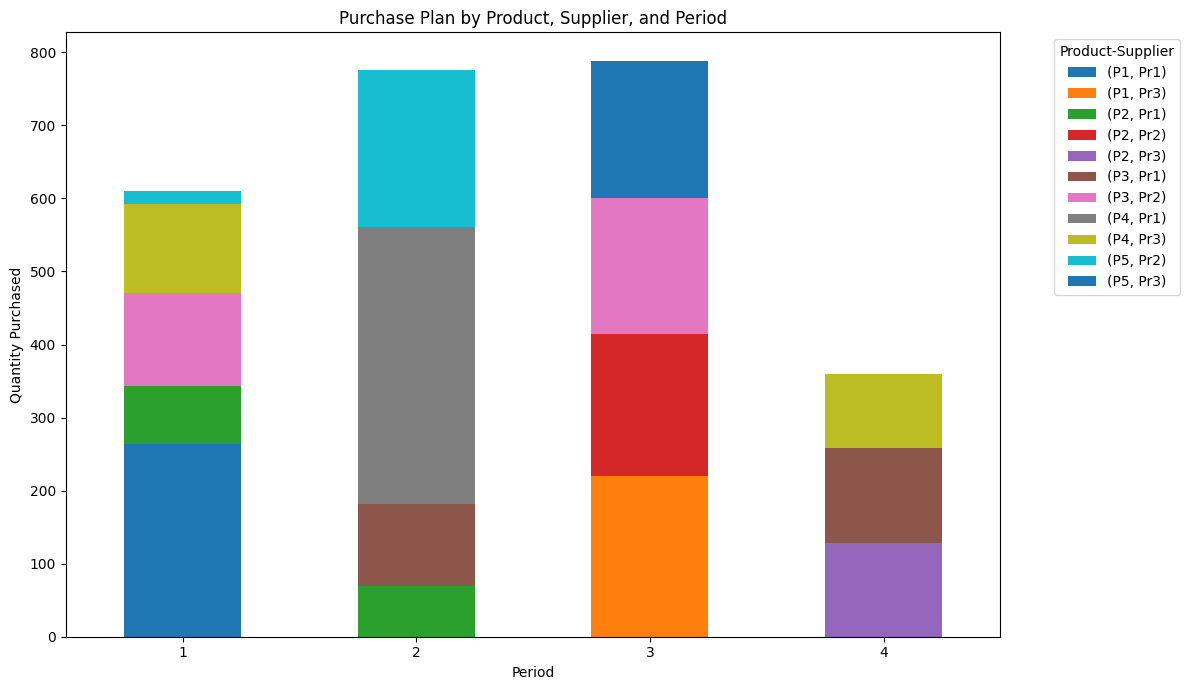

In [18]:
import matplotlib.pyplot as plt

ax = df_compras_pivot.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.title("Purchase Plan by Product, Supplier, and Period")
plt.xlabel("Period")
plt.ylabel("Quantity Purchased")
plt.xticks(rotation=0) # Rotate x-axis labels to be horizontal
plt.legend(title="Product-Supplier", bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside the plot
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

## Visualize stock levels

Create a visualization (a line plot) to show the stock level of each product over time, including the initial stock levels.


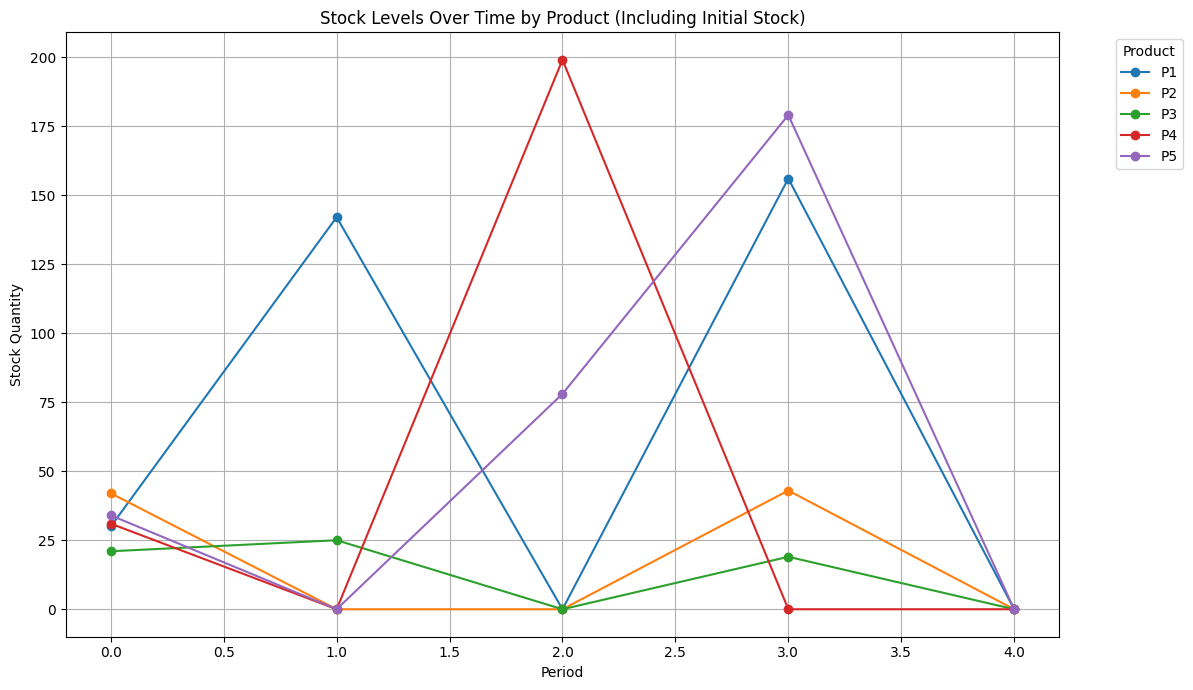

In [19]:
ax = df_stock_combined_pivot.plot(kind='line', figsize=(12, 7), marker='o')
plt.title("Stock Levels Over Time by Product (Including Initial Stock)")
plt.xlabel("Period")
plt.ylabel("Stock Quantity")
plt.legend(title="Product", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## Refine visualizations

### Subtask:
Refine the combined visualizations by ensuring consistent x-axis labeling and adding annotations or markers for key events (e.g., large purchases or significant stock changes).


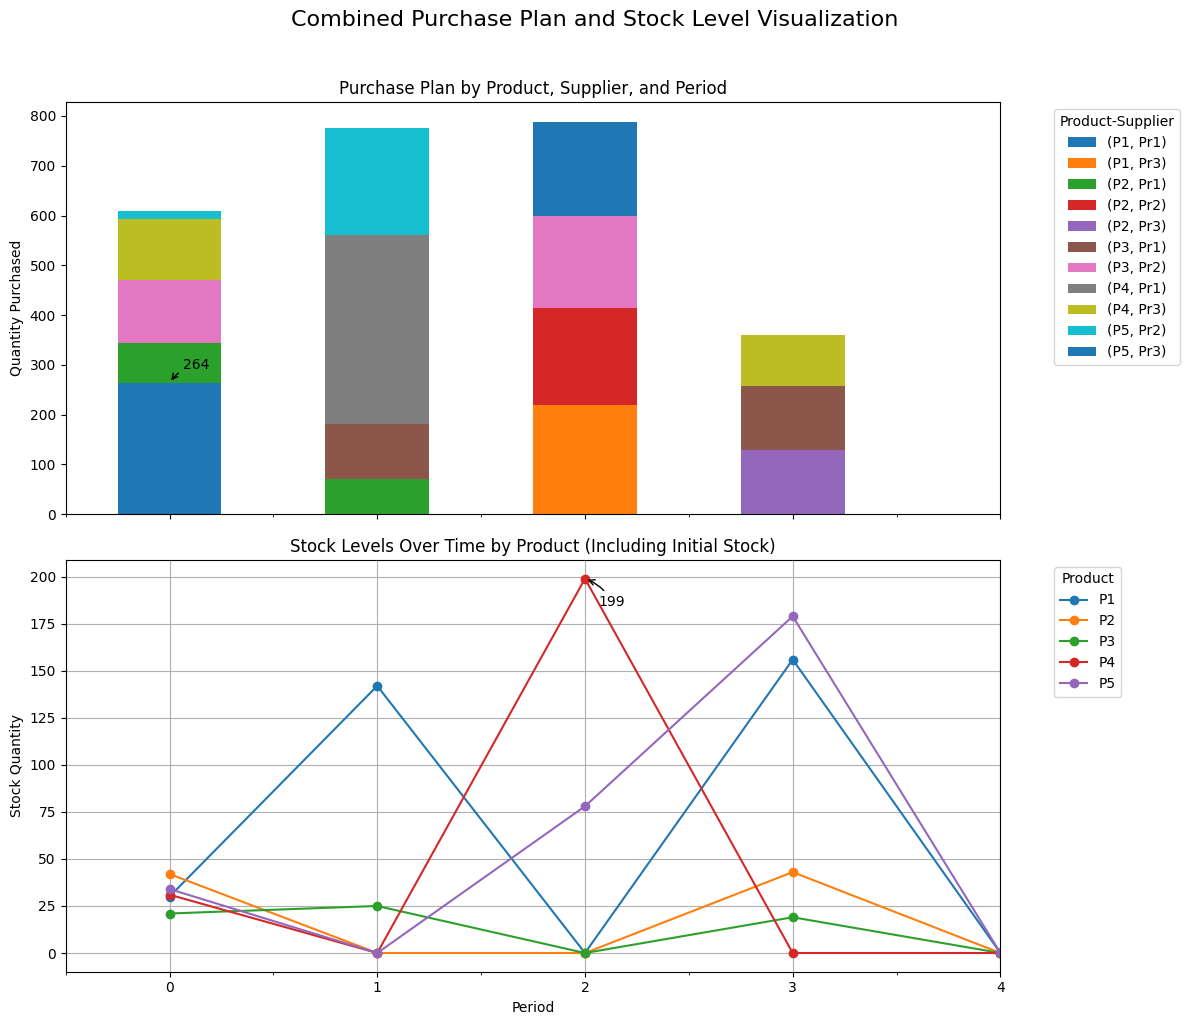

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot purchase plan (stacked bar chart)
df_compras_pivot.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title("Purchase Plan by Product, Supplier, and Period")
axes[0].set_ylabel("Quantity Purchased")
axes[0].legend(title="Product-Supplier", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].tick_params(axis='x', rotation=0)
axes[0].set_xticklabels(df_compras_pivot.index) # Ensure x-axis labels are period numbers

# Plot stock levels (line chart)
df_stock_combined_pivot.plot(kind='line', ax=axes[1], marker='o')
axes[1].set_title("Stock Levels Over Time by Product (Including Initial Stock)")
axes[1].set_xlabel("Period")
axes[1].set_ylabel("Stock Quantity")
axes[1].legend(title="Product", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True)
axes[1].set_xticks(df_stock_combined_pivot.index) # Align x-ticks with the bar chart periods
axes[1].set_xticklabels(df_stock_combined_pivot.index) # Ensure x-axis labels are period numbers

# Add a title to the overall figure
fig.suptitle("Combined Purchase Plan and Stock Level Visualization", y=1.02, fontsize=16)


# Optional: Add annotations for significant events (example: large purchase of P1 from Pr1 in T1)
# Find the purchase quantity for P1-Pr1 in Period 1
if ('P1', 'Pr1') in df_compras_pivot.columns:
  p1_pr1_t1_qty = df_compras_pivot.loc[1, ('P1', 'Pr1')]
  if p1_pr1_t1_qty > 100: # Annotate purchases greater than 100
      # Add annotation to the purchase plan chart
      axes[0].annotate(f'{p1_pr1_t1_qty:.0f}',
                       xy=(df_compras_pivot.index.get_loc(1), p1_pr1_t1_qty), # Use index location for x
                       xytext=(10, 10), textcoords='offset points',
                       arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))


# Optional: Add annotation for significant stock change (example: stock of P4 in T2)
if 'P4' in df_stock_combined_pivot.columns:
  p4_t2_stock = df_stock_combined_pivot.loc[2, 'P4']
  if p4_t2_stock > 100: # Annotate stock greater than 100
      # Add annotation to the stock level chart
      axes[1].annotate(f'{p4_t2_stock:.0f}',
                       xy=(df_stock_combined_pivot.index.get_loc(2), p4_t2_stock), # Use index location for x
                       xytext=(10, -20), textcoords='offset points',
                       arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))


plt.tight_layout()
plt.show()